In [12]:
# Standard imports
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from ieeg.auth import Session
from scipy import signal as sig
from scipy.integrate import simpson
from scipy.signal import coherence
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import minimize

import scipy as sc
from bct.algorithms import community_louvain
plt.rcParams['image.cmap'] = 'BuPu'

# ML Imports
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF,ConstantKernel
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
from sklearn.decomposition import NMF
from sklearn.utils import resample

# OS imports
import os
from os.path import join as ospj
from os.path import exists as ospe
import pathlib
from tqdm import tqdm
from pqdm.processes import pqdm
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
import mne

import os
os.environ["ETS_TOOLKIT"] = "qt4"
os.environ["QT_API"] = "pyqt5"

### Data Loading

In [13]:
metadata = pd.read_csv('../metadata_wchreject.csv')
# (metadata.cceps_hfs_seizure == 1) | 
metadata = metadata[(metadata.cceps_run1_sz == 1)].reset_index()
metadata.loc[:,'ieeg_id'] = 'HUP' + metadata.hupsubjno.apply(str) + '_phaseII'
metadata.loc[:,'ccep_id'] = 'HUP' + metadata.hupsubjno.apply(str) + '_CCEP'

In [14]:
with open('config.json','r') as f:
    CONFIG = json.load(f)
usr = CONFIG["paths"]["iEEG_USR"]
passpath = CONFIG["paths"]["iEEG_PWD"]
datapath = CONFIG["paths"]["RAW_DATA"]
prodatapath = CONFIG["paths"]["PROCESSED_DATA"]
ieeg_list = CONFIG["patients"]
rid_hup = pd.read_csv(ospj(datapath,'rid_hup.csv'))
pt_list = np.unique(np.array([i.split("_")[0] for i in ieeg_list]))

In [15]:
pt = "HUP235"
raw_datapath = ospj(datapath,pt)


In [16]:
dirty_drop_electrodes = metadata[metadata.hupsubjno == int(pt[-3:])]["final_reject_channels"].str.split(',').to_list()[0]
if isinstance(dirty_drop_electrodes,list):
        final_drop_electrodes = clean_labels(dirty_drop_electrodes,pt)
else:
    final_drop_electrodes = []

In [17]:
seizure_list = np.sort([s for s in os.listdir(ospj(raw_datapath, "seizures")) if 'preprocessed' in s])

In [18]:
seizure_list

array(['preprocessed_seizure_0_stim_1.pkl',
       'preprocessed_seizure_10_stim_0.pkl',
       'preprocessed_seizure_11_stim_0.pkl',
       'preprocessed_seizure_1_stim_0.pkl',
       'preprocessed_seizure_2_stim_0.pkl',
       'preprocessed_seizure_3_stim_0.pkl',
       'preprocessed_seizure_4_stim_0.pkl',
       'preprocessed_seizure_5_stim_0.pkl',
       'preprocessed_seizure_6_stim_0.pkl',
       'preprocessed_seizure_7_stim_0.pkl',
       'preprocessed_seizure_8_stim_0.pkl',
       'preprocessed_seizure_9_stim_2.pkl'], dtype='<U34')

In [19]:
all_seizures = []
all_ts = []
for seizure_path in seizure_list:
    seizure_fs = pd.read_pickle(ospj(raw_datapath,"seizures",seizure_path))
    fs = seizure_fs.fs.to_numpy()[-1]
    seizure = seizure_fs.drop("fs",axis=1)
    cols = seizure.columns.to_list()
    clean_ch = [c for c in cols if c not in final_drop_electrodes]
    seizure = seizure.loc[:,clean_ch]
    t = np.arange(0,len(seizure)/fs,1/fs)
    all_ts.append(t)
    all_seizures.append(seizure)
    # plot_iEEG_data(seizure,t)


### Sandboxing DTW

(<Figure size 4340.66x1440 with 1 Axes>, <Axes: xlabel='Time (s)'>)

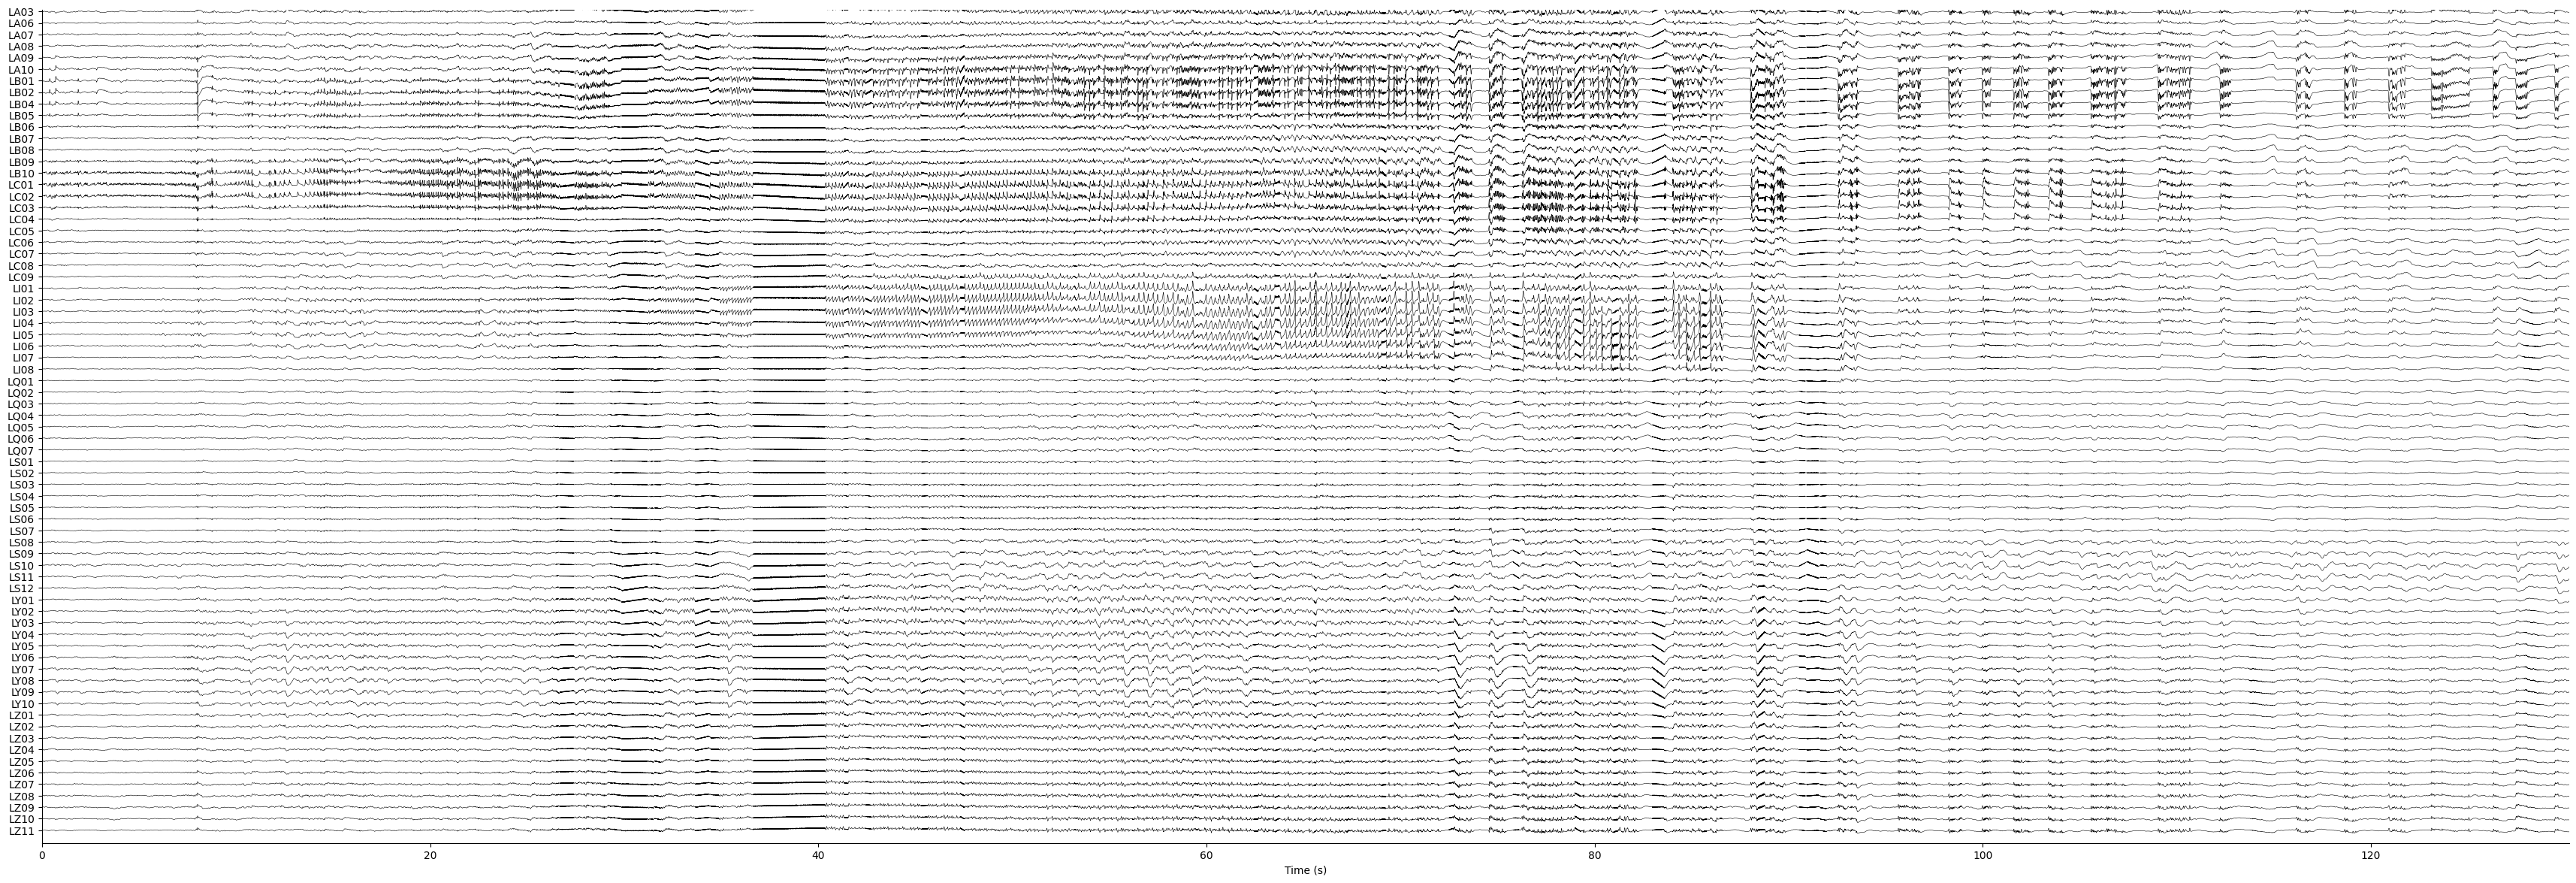

In [15]:
s = 2
plot_iEEG_data(all_seizures[s],all_ts[s])

#### Coh Generation

In [17]:
def calculate_coh_timeseries(data,fs=1024,win_len=10,stride=1,factor=2,freq_bands=[(1, 4), (4, 8), (8, 13), (13, 30), (30, 80), (80, 150)]):
    data = sig.decimate(data,factor,axis=0)
    data = pd.DataFrame(data,columns=all_seizures[1].columns)
    nfs = fs/factor

    # Simulate a DataFrame
    n_channels = data.shape[1]
    m_samples = data.shape[0]

    # Define frequency bands
    freq_bands = [(1, 4), (4, 8), (8, 13), (13, 30), (30, 80), (80, 150)]

    # Window parameters
    window_length = int(win_len * nfs)
    stride = int(stride*nfs)

    # Initialize lists to hold results
    all_coherences = []

    # Loop through each window
    for start in tqdm(range(0, m_samples - window_length + 1, stride)):
        window_data = data.iloc[start:start + window_length]
        coherence_matrix_list = []
        
        for low_f, high_f in freq_bands:
            coherences = []
            for i in range(n_channels):
                for j in range(i+1, n_channels):
                    f, Cxy = coherence(window_data.iloc[:, i], window_data.iloc[:, j], fs=fs)
                    avg_coh = np.mean(Cxy[(f >= low_f) & (f <= high_f)])
                    coherences.append(avg_coh)
            
            coherence_matrix_list.append(np.array(coherences))
        
        concatenated_coherence = np.concatenate(coherence_matrix_list)
        all_coherences.append(concatenated_coherence)
    # Convert to NumPy array and L1 normalize
    all_coherences = np.array(all_coherences)
    all_coherences = normalize(all_coherences, norm='l1', axis=1)
    return all_coherences


#### Coh Analysis

In [20]:
# with open(ospj(prodatapath,'all_coh_test.pkl'),'wb') as f:
#     pickle.dump(all_coherences,f)
with open(ospj(prodatapath,'all_coh_test.pkl'),'rb') as f:
    all_coherences = pickle.load(f)

In [70]:
# Stability-based NMF
n_bootstrap = 1e1  # Number of bootstrap samples
max_components = 10  # Maximum number of components to test
stability_scores = []

for k in tqdm(range(1, max_components + 1)):
    W_list = []
    
    for _ in range(int(n_bootstrap)):
        # Bootstrap resampling
        bootstrap_data = resample(all_coherences)
        
        # Perform NMF on bootstrap sample
        model = NMF(n_components=k, init='random', random_state=0)
        W = model.fit_transform(bootstrap_data)
        
        # Sort each component by size and store
        W_list.append(np.sort(W, axis=0))
        
    # Calculate stability score across bootstrap samples
    W_array = np.array(W_list)
    stability_score = np.mean(np.std(W_array, axis=0) / np.mean(W_array, axis=0))
    stability_scores.append(stability_score)

# Identify the number of components that gives the minimum stability score
optimal_k = np.argmin(stability_scores) + 1

# Perform NMF with optimal number of components
model = NMF(n_components=optimal_k, init='random', random_state=0)
W_optimal = model.fit_transform(all_coherences)
H_optimal = model.components_

100%|██████████| 10/10 [01:37<00:00,  9.71s/it]


In [72]:
recon_cohs = normalize(W_optimal@H_optimal,'l1',axis=1)

#### MDS Coh Plotting

In [74]:
def sammon(X, max_iter=1e10, tol=1e-9):
    pairwise_dissimilarities = squareform(pdist(X, metric='cityblock'))  # Using L1 distance
    plt.imshow(pairwise_dissimilarities)
    init = np.random.rand(X.shape[0], 2)  # Random 2D initialization
    
    def stress(Y):
        Y = Y.reshape((X.shape[0], 2))
        d = squareform(pdist(Y))
        d[d == 0] = 1  # Prevent division by zero
        ratio = pairwise_dissimilarities / d
        return np.sum((pairwise_dissimilarities - d)**2 * ratio)
    
    res = minimize(stress, init.ravel(), method='L-BFGS-B', tol=tol, options={'maxiter': max_iter, 'disp': True})
    return res.x.reshape((X.shape[0], 2))


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          246     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.80867D+02    |proj g|=  3.02249D+03

At iterate    1    f=  8.96823D+02    |proj g|=  3.58567D+02

At iterate    2    f=  8.54845D+02    |proj g|=  1.65901D+02

At iterate    3    f=  8.23977D+02    |proj g|=  7.52798D+01

At iterate    4    f=  7.59943D+02    |proj g|=  7.16512D+01

At iterate    5    f=  6.85663D+02    |proj g|=  1.65976D+02

At iterate    6    f=  6.62139D+02    |proj g|=  1.29169D+02

At iterate    7    f=  6.33242D+02    |proj g|=  5.40784D+01


 This problem is unconstrained.



At iterate    8    f=  5.77566D+02    |proj g|=  3.76271D+02

At iterate    9    f=  5.62665D+02    |proj g|=  5.44755D+01

At iterate   10    f=  5.48341D+02    |proj g|=  9.39252D+01

At iterate   11    f=  5.28099D+02    |proj g|=  2.08233D+02

At iterate   12    f=  5.05758D+02    |proj g|=  5.85145D+01

At iterate   13    f=  4.81595D+02    |proj g|=  5.08937D+01

At iterate   14    f=  4.44342D+02    |proj g|=  2.12682D+03

At iterate   15    f=  4.41151D+02    |proj g|=  2.61601D+02

At iterate   16    f=  4.37419D+02    |proj g|=  1.27856D+02

At iterate   17    f=  4.32596D+02    |proj g|=  2.57896D+02

At iterate   18    f=  4.17277D+02    |proj g|=  9.35878D+01

At iterate   19    f=  4.11276D+02    |proj g|=  6.23390D+01

At iterate   20    f=  3.98561D+02    |proj g|=  3.88965D+01

At iterate   21    f=  3.91948D+02    |proj g|=  1.88109D+02

At iterate   22    f=  3.65872D+02    |proj g|=  1.22127D+02

At iterate   23    f=  3.55189D+02    |proj g|=  4.89157D+01

At iter

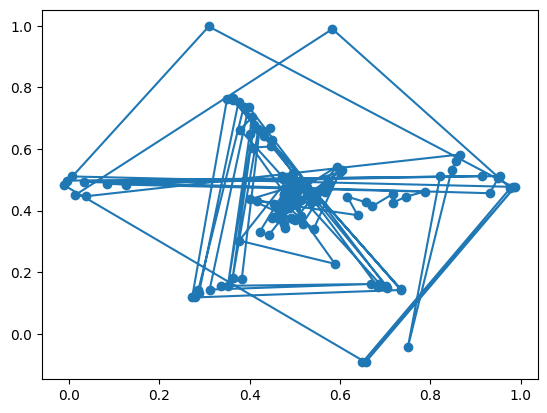

In [75]:
embeddings = sammon(recon_cohs)
plt.figure()
plt.plot(embeddings[:,0],embeddings[:,1],'o-')

### Sandboxing Clustering

In [16]:
def nonstationary_bandpower(x: np.ndarray, fs: float, lo_stop=1, hi_stop=120, relative=True, win_size=2, win_stride=1) -> np.array:
    """
    Calculates the relative bandpower of a signal x, using a butterworth filter of order 'order'
    and bandpass filter between lo and hi Hz.

    Use scipy.signal.welch and scipy.integrate.simpson
    """
    
    bands = {"delta": (1, 4), "theta": (4, 8), "alpha": (8, 12), "beta": (12, 30), "gamma": (30, 80)}
    bands = {"broad": (6,100)}
    nperseg = int(win_size * fs)
    noverlap = nperseg - int(win_stride * fs)

    # freq, pxx = sig.welch(x=x, fs=fs, nperseg=nperseg, noverlap=noverlap, axis=1)
    freq,t,Sxx = sig.spectrogram(x=x,fs=fs,nperseg=nperseg,noverlap=noverlap,axis=1)
    filter_idxs = (freq > lo_stop) & (freq < hi_stop)
    # log transform the power spectrum
    # pxx = 10*np.log10(pxx)
    
    all_bands = np.zeros((Sxx.shape[0],len(bands),Sxx.shape[2]))
    for i, (_, (lo, hi)) in enumerate(bands.items()):
        idx_band = np.logical_and(freq >= lo, freq <= hi)
        bp = simpson(Sxx[:, idx_band,:], dx=freq[1] - freq[0],axis=1)
        # relative
        if relative:
            bp /= simpson(Sxx[:,filter_idxs,:], dx=freq[1] - freq[0],axis=1)
        all_bands[:, i,:] = bp
    return all_bands,t
    # return bp
    # return data_filt
bp = nonstationary_bandpower(seizure.to_numpy().T,fs)

In [17]:
bp.shape

(72, 1, 94)

In [18]:
seizure_signals,_ = [nonstationary_bandpower(x.T,fs,win_size=1,win_stride=.5,relative=True).squeeze() for x in all_seizures];

In [57]:
n1 = 1
n2 = 1
# s1 = seizure_signals[n1]
s1 = s2 = all_coherences.T
# s2 = seizure_signals[n2]
seizure_comparison = np.zeros((s1.shape[1],s2.shape[1]))
for i in range(s1.shape[1]):
    for j in range(s2.shape[1]):
        c = np.corrcoef(s1[:,i],s2[:,j])
        c_element = np.abs(c[0,1]) * (1-0.2*np.abs(i-j)/s1.shape[0])
        seizure_comparison[i,j] = c_element

In [140]:
seizure_comparison = 1-squareform(pdist(recon_cohs,metric='cityblock'))

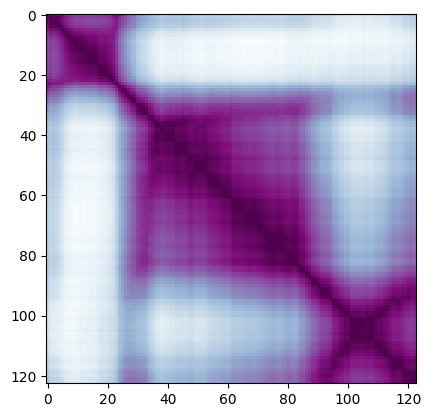

In [141]:
plt.imshow(seizure_comparison)

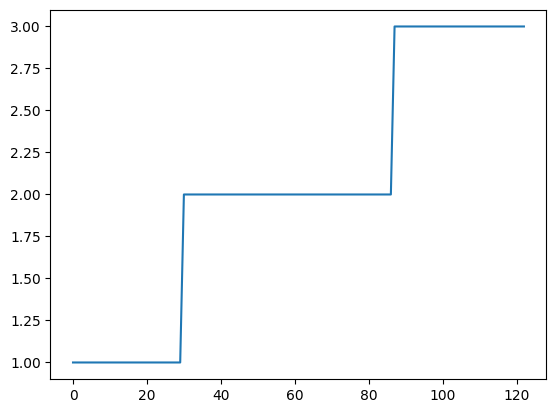

In [143]:
all_ass = []
for s in range(50):
    assignments,_ = community_louvain(seizure_comparison,1,seed=s)
    all_ass.append(assignments)
all_ass = np.array(all_ass)
raw_assignments,_ = sc.stats.mode(all_ass,axis=0)
filt_assignments = sig.medfilt(raw_assignments,7)
plt.plot(raw_assignments)

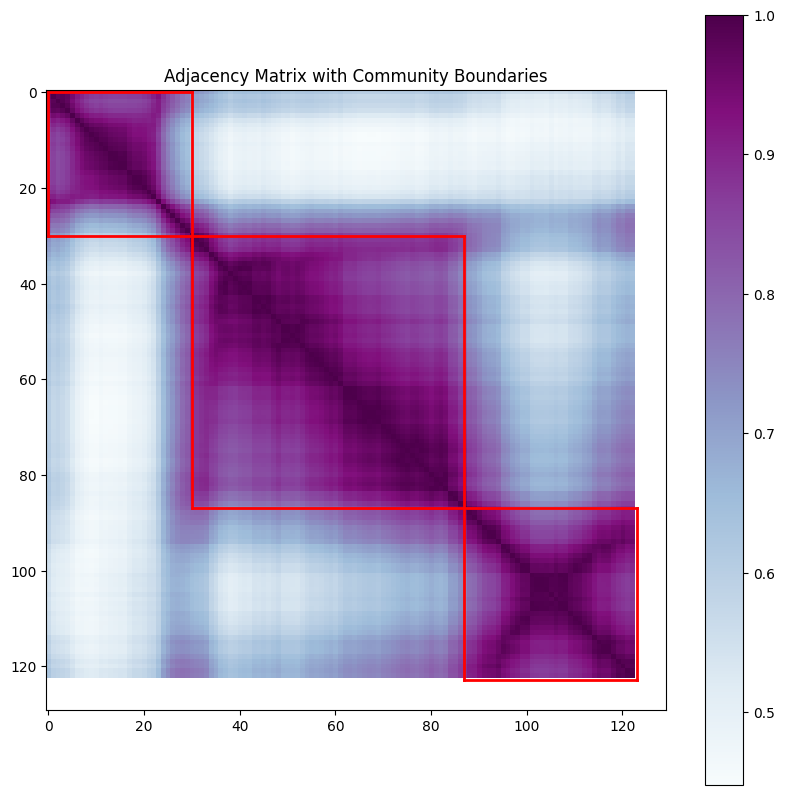

In [144]:
plt.figure(figsize=(10, 10))
order = np.argsort(filt_assignments)

plt.imshow(seizure_comparison)
plt.colorbar()
# Drawing the community boundaries
current_x = 0

for module in np.unique(filt_assignments):
    size = np.sum(filt_assignments[order] == module)
    plt.plot([current_x, current_x + size], [current_x, current_x], 'r', linewidth=2)
    
    # Left boundary
    plt.plot([current_x, current_x], [current_x, current_x + size], 'r', linewidth=2)
    
    # Bottom boundary
    plt.plot([current_x, current_x + size], [current_x + size, current_x + size], 'r', linewidth=2)
    
    # Right boundary
    plt.plot([current_x + size, current_x + size], [current_x, current_x + size], 'r', linewidth=2)
    
    current_x += size


plt.title('Adjacency Matrix with Community Boundaries')
plt.show()
